In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from ptsne.ptsne import ParametricTSNE

# Datasets & Loaders

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
cifar_train = CIFAR10(
    './data',
    train=True,
    download=True,
    transform=transform
)

cifar_test = CIFAR10(
    './data',
    train=False,
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainloader = torch.utils.data.DataLoader(cifar_train,
    batch_size=50,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

trainloader_noshuffle = torch.utils.data.DataLoader(cifar_train,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

testloader = torch.utils.data.DataLoader(cifar_test,
    batch_size=200,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

# Classifier Network

In [47]:
class Net(nn.Module):
    def __init__(self, use_cuda=True):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 100)
        self.fc3 = nn.Linear(100, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
class Net2(nn.Module):
    def __init__(self, use_cuda=True):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.2)
        self.dense = nn.Linear(512, 10)
        self.use_cuda = use_cuda
        if self.use_cuda:
            self.cuda()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = x.view(-1, 512)
        x = F.relu(self.dense(x))
        return x

In [42]:
def train(log_interval, model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_altered(log_interval, model, device, altered_loader, embedding, optimizer, epoch, weight):
    model.train()
    for batch_idx, (data, target, label) in enumerate(altered_loader):
        data, target, label = data.to(device), target.to(device), label.to(device)
        optimizer.zero_grad()
        output = model.forward(data)
        class_loss = torch.nn.CrossEntropyLoss()(output, label)
        embedding_loss = torch.nn.MSELoss()(embedding(output), target) / len(label)
        loss = (1 - weight) * class_loss + weight * embedding_loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(altered_loader.dataset),
                100. * batch_idx / len(altered_loader), loss.item()))

def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # sum up batch loss
            test_loss += criterion(output, target).cpu().item()
            pred = output.argmax(dim=1)
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Train Initial Network

In [49]:
net = Net2()
# net.load_state_dict(torch.load('models/cifar-test-model.pt'))

In [50]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [51]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)

torch.backends.cudnn.deterministic=True

In [52]:
for epoch in range(1, 6):
        # log run every epoch

        train(200, net, 'cuda', trainloader, optimizer, criterion, epoch)
        #test(net, 'cuda', testloader, criterion)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.305017
Train Epoch: 1 [10000/50000 (20%)]	Loss: 2.299423
Train Epoch: 1 [20000/50000 (40%)]	Loss: 2.040698
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.890902
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.855433
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.595918
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.706061
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.413754
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.190566
Train Epoch: 2 [40000/50000 (80%)]	Loss: 1.456998
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.152985
Train Epoch: 3 [10000/50000 (20%)]	Loss: 1.205928
Train Epoch: 3 [20000/50000 (40%)]	Loss: 1.003705
Train Epoch: 3 [30000/50000 (60%)]	Loss: 1.038551
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.937842
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.917596
Train Epoch: 4 [10000/50000 (20%)]	Loss: 0.933327
Train Epoch: 4 [20000/50000 (40%)]	Loss: 0.781313
Train Epoch: 4 [30000/50000 (60%)]	Loss: 0.958466
Train Epoch: 4 [40000/50000 (80%)]	Loss: 1.074350
Train Epoch: 5 [0/50

In [54]:
torch.save(net.state_dict(), 'models/cifar-new-before.pt')

# Embedding

In [53]:
net.eval()
with torch.no_grad():
    logits_train = []
    for data, targets in trainloader_noshuffle:
        data = data.cuda()
        logits_train.append(net(data).detach().cpu())
logits_train = torch.cat(logits_train)

with torch.no_grad():
    logits_test = []
    for data, targets in testloader:
        data = data.cuda()
        logits_test.append(net(data).detach().cpu())
logits_test = torch.cat(logits_test)

In [58]:
ptsne = ParametricTSNE(10, 2, 50, use_cuda=True, hidden_layer_dims=[300,100], alpha=1)
# ptsne.load_state_dict(torch.load('models/ptsne-test.pt'))

In [59]:
#ptsne.fit(outputs, pretrain=True,verbose=True)
ptsne.fit(logits_train[::12], pretrain=True, verbose=True)

Calculating PCA
2020-03-05 13:33:42.033556: Beginning pretraining for 5 epochs
2020-03-05 13:33:42.140271: Loss after epoch 0: 58.775264263153076
2020-03-05 13:33:42.235017: Loss after epoch 1: 7.1862219870090485
2020-03-05 13:33:42.333752: Loss after epoch 2: 3.423825040459633
2020-03-05 13:33:42.426539: Loss after epoch 3: 1.4930833876132965
2020-03-05 13:33:42.513308: Loss after epoch 4: 0.8175522312521935
2020-03-05 13:33:42.513308: Finished pretraining
Indexing
2020-03-05 13:34:06.749544: Beginning training for 10 epochs
2020-03-05 13:34:07.038769: Loss after epoch 1: 19.294155872069382
2020-03-05 13:34:07.301068: Loss after epoch 2: 18.21472166182798
2020-03-05 13:34:07.584310: Loss after epoch 3: 18.000449584722364
2020-03-05 13:34:07.865558: Loss after epoch 4: 17.514013981223712
2020-03-05 13:34:08.156287: Loss after epoch 5: 17.554308889193944
2020-03-05 13:34:08.455487: Loss after epoch 6: 17.51446147308693
2020-03-05 13:34:08.753255: Loss after epoch 7: 17.513637156356342
2

In [60]:
torch.save(ptsne.state_dict(), 'models/cifar-new-ptsne.pt')

In [61]:
ptsne.eval()
projected_train = ptsne(logits_train.cuda()).detach().cpu()
projected_test = ptsne(logits_test.cuda()).detach().cpu()

# Determine Suitable Shifts

In [55]:
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

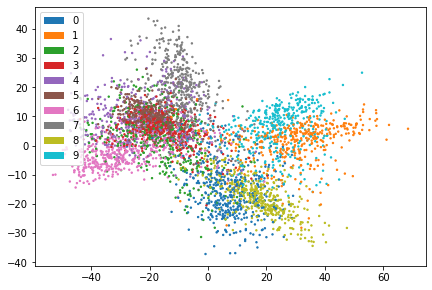

In [62]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_train.targets[::12]]
ax.scatter(projected_train[::12,0], projected_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [65]:
# shift = (torch.tensor(cifar_train.targets) == 9).float().unsqueeze(1) * torch.tensor([0.,-10.]) #+ (torch.tensor(cifar_train.targets) == 4).float().unsqueeze(1) * torch.tensor([8.,0.])
# shifted_train = projected_train + shift
shift = (torch.tensor(cifar_train.targets) == 3).float().unsqueeze(1) * torch.tensor([30.,20.]) #+ (torch.tensor(cifar_train.targets) == 4).float().unsqueeze(1) * torch.tensor([8.,0.])
shifted_train = projected_train + shift

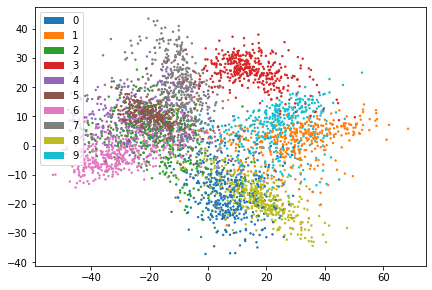

In [66]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_train.targets[::12]]
ax.scatter(shifted_train[::12,0], shifted_train[::12,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

# Retraining

In [67]:
cifar_train_for_loader = []
for data, target in trainloader_noshuffle:
    cifar_train_for_loader.append(data)
cifar_train_for_loader = torch.cat(cifar_train_for_loader)

In [68]:
shifted_dataset = torch.utils.data.TensorDataset(cifar_train_for_loader, shifted_train, torch.tensor(cifar_train.targets))
shifted_loader = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=True)
shifted_loader_noshuffle = torch.utils.data.DataLoader(shifted_dataset, batch_size=50, shuffle=False)

In [94]:
net = Net2()
net.load_state_dict(torch.load('models/cifar-new-before.pt'))

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

for epoch in range(5):
    train_altered(200, net, 'cuda', shifted_loader, ptsne, optimizer, epoch, 0.5)

torch.save(net.state_dict(), 'models/cifar-new-after.pt')

Train Epoch: 0 [0/50000 (0%)]	Loss: 1.068435
Train Epoch: 0 [10000/50000 (20%)]	Loss: 1.170204
Train Epoch: 0 [20000/50000 (40%)]	Loss: 1.477196
Train Epoch: 0 [30000/50000 (60%)]	Loss: 0.891418
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.939994
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.886887
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.632332
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.979771
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.588240
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.769343
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.740485
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.780678
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.618247
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.807521
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.811559
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.785106
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.744729
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.752704
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.891603
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.948057
Train Epoch: 4 [0/50

In [95]:
net.eval()
with torch.no_grad():
    new_projected_train = []
    new_logits_train = []
    for data, targets in trainloader_noshuffle:
        out = net(data.cuda())
        new_logits_train.append(out.detach().cpu())
        new_projected_train.append(ptsne(out).detach().cpu())
new_projected_train = torch.cat(new_projected_train)
new_logits_train = torch.cat(new_logits_train)

In [96]:
net.eval()
with torch.no_grad():
    new_projected_test = []
    new_logits_test = []
    for data, targets in testloader:
        out = net(data.cuda())
        new_logits_test.append(out.detach().cpu())
        new_projected_test.append(ptsne(out).detach().cpu())
new_projected_test = torch.cat(new_projected_test)
new_logits_test = torch.cat(new_logits_test)

# Evaluation

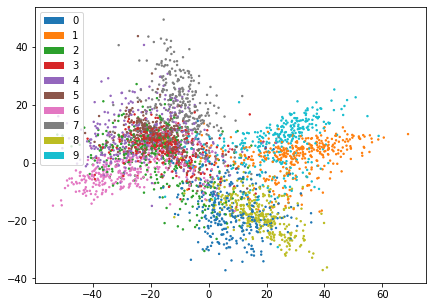

In [73]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_test.targets[::3]]
ax.scatter(projected_test[::3,0], projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

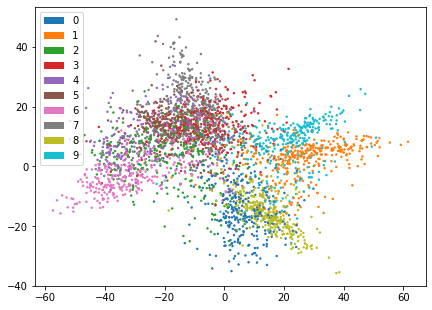

In [97]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in cifar_test.targets[::3]]
ax.scatter(new_projected_test[::3,0], new_projected_test[::3,1], c=colors, s=2)
ax.set_aspect(1)
recs = []
for i in range(0,10):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs,list(range(10)),loc=2)

In [88]:
cf_train = torch.zeros(10,10, dtype=int)
for i in zip(cifar_train.targets, logits_train.argmax(dim=1)):
    cf_train[i] += 1

cf_test = torch.zeros(10,10, dtype=int)
for i in zip(cifar_test.targets, logits_test.argmax(dim=1)):
    cf_test[i] += 1

In [98]:
new_cf_train = torch.zeros(10,10, dtype=int)
for i in zip(cifar_train.targets, new_logits_train.argmax(dim=1)):
    new_cf_train[i] += 1

new_cf_test = torch.zeros(10,10, dtype=int)
for i in zip(cifar_test.targets, new_logits_test.argmax(dim=1)):
    new_cf_test[i] += 1

In [90]:
cf_test.diag().sum().float() / cf_test.sum().float()

tensor(0.7248)

In [99]:
new_cf_test.diag().sum().float() / new_cf_test.sum().float()

tensor(0.7347)

In [92]:
# print(cf_test[1,1].float() / cf_test[:,1].sum().float()) # precision 'Auto'
# print(cf_test[1,1].float() / cf_test[1,:].sum().float()) # recall

# print(cf_test[9,9].float() / cf_test[:,9].sum().float()) # precision 'Truck'
# print(cf_test[9,9].float() / cf_test[9,:].sum().float()) # recall

print(cf_test[3,3].float() / cf_test[:,3].sum().float()) # precision 'Cat'
print(cf_test[3,3].float() / cf_test[3,:].sum().float()) # recall

tensor(0.5431)
tensor(0.5550)


In [100]:
# print(new_cf_test[1,1].float() / new_cf_test[:,1].sum().float()) # precision 'Auto'
# print(new_cf_test[1,1].float() / new_cf_test[1,:].sum().float()) # recall

# print(new_cf_test[9,9].float() / new_cf_test[:,9].sum().float()) # precision 'Truck'
# print(new_cf_test[9,9].float() / new_cf_test[9,:].sum().float()) # recall

print(new_cf_test[3,3].float() / new_cf_test[:,3].sum().float()) # precision 'Cat'
print(new_cf_test[3,3].float() / new_cf_test[3,:].sum().float()) # recall

tensor(0.5675)
tensor(0.6350)


In [83]:
cifar_test.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [104]:
results = []

for ratio in torch.arange(0,1.1,0.1):
    ratio = ratio.item()
    net = Net2()
    net.load_state_dict(torch.load('models/cifar-new-before.pt'))

    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(5):
        train_altered(200, net, 'cuda', shifted_loader, ptsne, optimizer, epoch, ratio)

    net.eval()
    with torch.no_grad():
        #new_projected_test = []
        new_logits_test = []
        for data, targets in testloader:
            out = net(data.cuda())
            new_logits_test.append(out.detach().cpu())
            #new_projected_test.append(ptsne(out).detach().cpu())
    #new_projected_test = torch.cat(new_projected_test)
    new_logits_test = torch.cat(new_logits_test)

    new_cf_test = torch.zeros(10,10, dtype=int)
    for i in zip(cifar_test.targets, new_logits_test.argmax(dim=1)):
        new_cf_test[i] += 1

    accuracy = new_cf_test.diag().sum().float() / new_cf_test.sum().float()
    cat_prec = new_cf_test[3,3].float() / new_cf_test[:,3].sum().float()
    cat_rec = new_cf_test[3,3].float() / new_cf_test[3,:].sum().float()

    results.append([accuracy, cat_prec, cat_rec])

Train Epoch: 0 [0/50000 (0%)]	Loss: 0.721744
Train Epoch: 0 [10000/50000 (20%)]	Loss: 0.713990
Train Epoch: 0 [20000/50000 (40%)]	Loss: 0.939870
Train Epoch: 0 [30000/50000 (60%)]	Loss: 0.950819
Train Epoch: 0 [40000/50000 (80%)]	Loss: 0.690988
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.760600
Train Epoch: 1 [10000/50000 (20%)]	Loss: 0.660827
Train Epoch: 1 [20000/50000 (40%)]	Loss: 0.563046
Train Epoch: 1 [30000/50000 (60%)]	Loss: 0.388708
Train Epoch: 1 [40000/50000 (80%)]	Loss: 0.571958
Train Epoch: 2 [0/50000 (0%)]	Loss: 0.535678
Train Epoch: 2 [10000/50000 (20%)]	Loss: 0.634249
Train Epoch: 2 [20000/50000 (40%)]	Loss: 0.591822
Train Epoch: 2 [30000/50000 (60%)]	Loss: 0.627189
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.654051
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.589973
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.558302
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.693852
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.567169
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.535922
Train Epoch: 4 [0/50

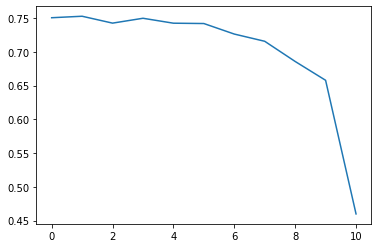

In [109]:
plt.plot(torch.tensor(results)[:,0])

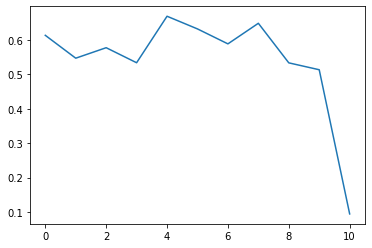

In [110]:
plt.plot(torch.tensor(results)[:,1])


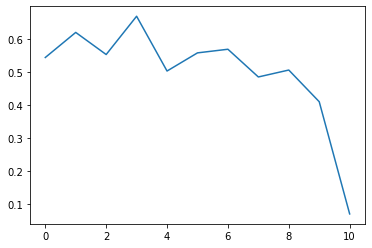

In [111]:
plt.plot(torch.tensor(results)[:,2])

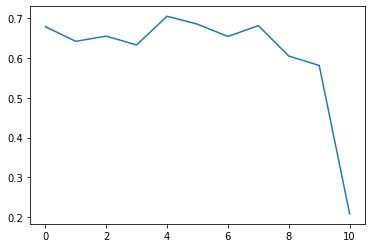

In [115]:
plt.plot(torch.sqrt(torch.tensor(results)[:,0] * torch.tensor(results)[:,1]))